In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.feature_selection import chi2
from sklearn.feature_selection import SelectKBest
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, OrdinalEncoder

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv("bank.csv", delimiter=";")

In [3]:
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,30,unemployed,married,primary,no,1787,no,no,cellular,19,oct,79,1,-1,0,unknown,no
1,33,services,married,secondary,no,4789,yes,yes,cellular,11,may,220,1,339,4,failure,no
2,35,management,single,tertiary,no,1350,yes,no,cellular,16,apr,185,1,330,1,failure,no
3,30,management,married,tertiary,no,1476,yes,yes,unknown,3,jun,199,4,-1,0,unknown,no
4,59,blue-collar,married,secondary,no,0,yes,no,unknown,5,may,226,1,-1,0,unknown,no


In [4]:
# get numerical data only
numeric_data = df.select_dtypes(include=['int64'])
numeric_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4521 entries, 0 to 4520
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   age       4521 non-null   int64
 1   balance   4521 non-null   int64
 2   day       4521 non-null   int64
 3   duration  4521 non-null   int64
 4   campaign  4521 non-null   int64
 5   pdays     4521 non-null   int64
 6   previous  4521 non-null   int64
dtypes: int64(7)
memory usage: 247.4 KB


In [5]:
# get categorical data
cat_data = df.select_dtypes(include=['object'])
cat_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4521 entries, 0 to 4520
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   job        4521 non-null   object
 1   marital    4521 non-null   object
 2   education  4521 non-null   object
 3   default    4521 non-null   object
 4   housing    4521 non-null   object
 5   loan       4521 non-null   object
 6   contact    4521 non-null   object
 7   month      4521 non-null   object
 8   poutcome   4521 non-null   object
 9   y          4521 non-null   object
dtypes: object(10)
memory usage: 353.3+ KB


## Feature Selection

**Chi-Squared Feature Selection**

Pearson’s chi-squared statistical hypothesis test is an example of a test for independence between categorical variables.

The results of this test can be used for feature selection, where those features that are independent of the target variable can be removed from the dataset.

The scikit-learn machine library provides an implementation of the chi-squared test in the chi2() function. This function can be used in a feature selection strategy, such as selecting the top k most relevant features (largest values) via the SelectKBest class.

For example, we can define the SelectKBest class to use the chi2() function and select all features, then transform the train and test sets.

https://machinelearningmastery.com/feature-selection-with-categorical-data/

We have a DataFrame with only the categorical data from our EDA, we'll use that to perform this analysis.

In [6]:
cat_data.head()

,job,marital,education,default,housing,loan,contact,month,poutcome,y
0,unemployed,married,primary,no,no,no,cellular,oct,unknown,no
1,services,married,secondary,no,yes,yes,cellular,may,failure,no
2,management,single,tertiary,no,yes,no,cellular,apr,failure,no
3,management,married,tertiary,no,yes,yes,unknown,jun,unknown,no
4,blue-collar,married,secondary,no,yes,no,unknown,may,unknown,no


In [7]:
X = cat_data.iloc[:, :-1].values
y = cat_data.iloc[:,-1].values

In [8]:
oe = OrdinalEncoder(handle_unknown='error')
oe.fit(X)
X = oe.transform(X)

In [9]:
# split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)

In [10]:
fs = SelectKBest(score_func=chi2, k='all')
fs.fit(X_train, y_train)
#X_train_fs = fs.transform(X_train)
#X_test_fs = fs.transform(X_test)

SelectKBest(k='all', score_func=<function chi2 at 0x14a5c0160>)

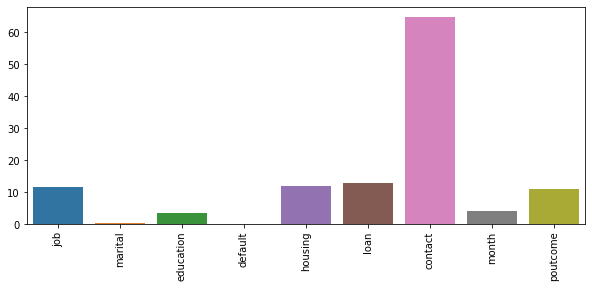

In [11]:
# what are scores for the features
names = []
values = []
for i in range(len(fs.scores_)):
    names.append(cat_data.columns[i])
    values.append(fs.scores_[i])
chi_list = zip(names, values)

# plot the scores
plt.figure(figsize=(10,4))
sns.barplot(x=names, y=values)
plt.xticks(rotation = 90)
plt.show()